## Used to do some tests on preprocessing before implementing in proprecessing.py

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

sns.set_style("whitegrid")

## Load Data

In [27]:
data_folder = '../data/'

train_file = 'train.csv'
test_file = 'test.csv'

train_path = data_folder + train_file
test_path = data_folder + test_file

In [28]:
df_train = pd.read_csv(train_path).rename(columns={'KPI ID': 'kpi_id'})
print(df_train.shape)
df_train.head(2)

(2476315, 4)


,timestamp,value,label,kpi_id
0,1493568000,1.901639,0,02e99bd4f6cfb33f
1,1493568060,1.786885,0,02e99bd4f6cfb33f


In [29]:
df_test = pd.read_csv(test_path).rename(columns={'KPI ID': 'kpi_id'})
print(df_test.shape)
df_test.head(2)

(2345211, 3)


,timestamp,value,kpi_id
0,1501475700,2.719298,02e99bd4f6cfb33f
1,1501475760,2.456140,02e99bd4f6cfb33f


In [30]:
df_train['datetime'] = pd.to_datetime(df_train.timestamp, unit='s')
df_test['datetime'] = pd.to_datetime(df_test.timestamp, unit='s')

## Pre-processing

### Before train/val split

#### fill na

In [31]:
df_train.isna().sum(axis=0)

timestamp    0
value        0
label        0
kpi_id       0
datetime     0
dtype: int64

In [32]:
df_test.isna().sum(axis=0)

timestamp    0
value        0
kpi_id       0
datetime     0
dtype: int64

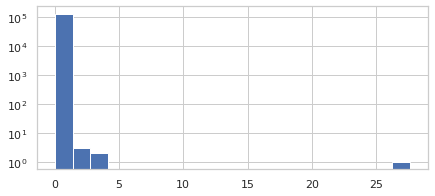

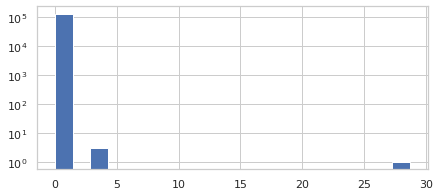

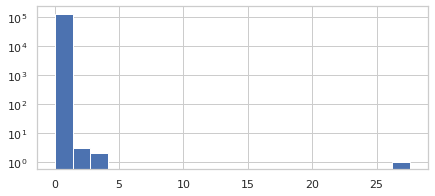

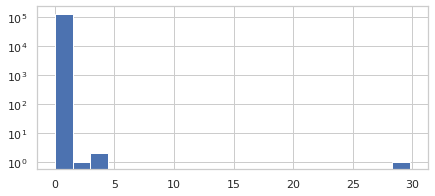

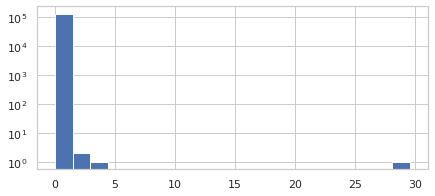

kpi_id
02e99bd4f6cfb33f    (AxesSubplot(0.125,0.125;0.775x0.755), None)
18fbb1d5a5dc099d    (AxesSubplot(0.125,0.125;0.775x0.755), None)
9bd90500bfd11edb    (AxesSubplot(0.125,0.125;0.775x0.755), None)
a5bf5d65261d859a    (AxesSubplot(0.125,0.125;0.775x0.755), None)
da403e4e3f87c9e0    (AxesSubplot(0.125,0.125;0.775x0.755), None)
dtype: object

In [35]:
# Plot the time interval between timestamps for each kpi_id. Train set

df_train[df_train.kpi_id.isin(df_train.kpi_id.unique()[:5])].groupby('kpi_id').apply(lambda x:
                                                                                     ((x.timestamp.diff() / 60 / 60).hist(log=True, bins=20, figure=plt.figure(figsize=(7, 3))), plt.show()))

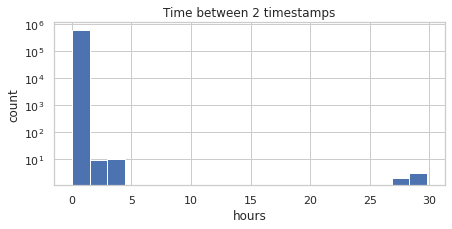

In [39]:
# Plot the time interval between timestamps for each kpi_id. Train set

diffs = df_train[df_train.kpi_id.isin(df_train.kpi_id.unique()[:5])].groupby('kpi_id').apply(lambda x:
                                                                                     (x.timestamp.diff() / 60 / 60)).reset_index(drop=True)
diffs.hist(log=True, bins=20, figure=plt.figure(figsize=(7, 3)))
plt.title('Time between 2 timestamps')
plt.xlabel('hours')
plt.ylabel('count')
plt.show()

In [42]:
df_train.datetime

0         2017-04-30 16:00:00
1         2017-04-30 16:01:00
2         2017-04-30 16:02:00
3         2017-04-30 16:03:00
4         2017-04-30 16:04:00
                  ...        
2476310   2017-06-08 04:15:00
2476311   2017-06-08 04:16:00
2476312   2017-06-08 04:17:00
2476313   2017-06-08 04:18:00
2476314   2017-06-08 04:19:00
Name: datetime, Length: 2476315, dtype: datetime64[ns]

In [9]:
df_train.timestamp.diff().value_counts().iloc[:3]

60.0     2388846
300.0      62321
120.0      23594
Name: timestamp, dtype: int64

The target frequency seems to be one minute

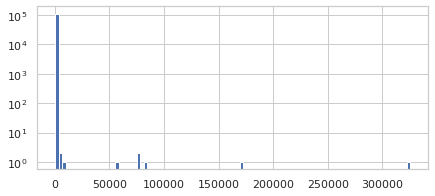

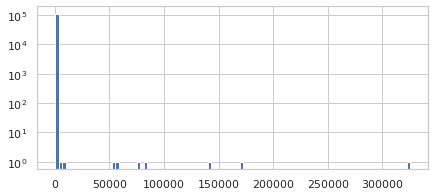

kpi_id
02e99bd4f6cfb33f    (AxesSubplot(0.125,0.125;0.775x0.755), None)
9bd90500bfd11edb    (AxesSubplot(0.125,0.125;0.775x0.755), None)
dtype: object

In [44]:
# Plot the time interval between timestamps for each kpi_id. Test set

df_test[df_test.kpi_id.isin(df_test.kpi_id.unique()[:2])].groupby('kpi_id').apply(lambda x:
                                                                                     (x.timestamp.diff().hist(log=True, bins=100, figure=plt.figure(figsize=(7, 3))), plt.show()))

In [51]:
df_train.kpi_id.unique().size

26

Text(0.5, 8.960000000000022, 'missing dates count')

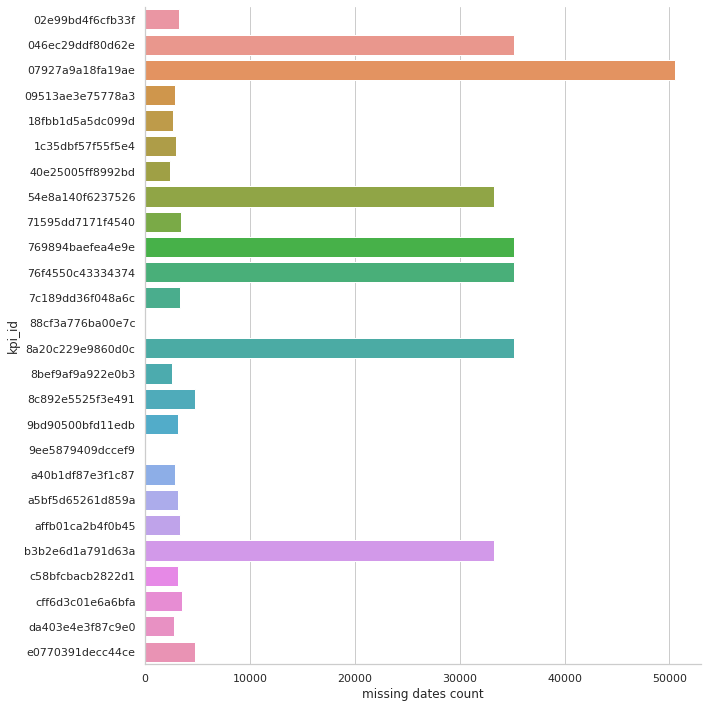

In [45]:
# Plot the number of missing dates (with 1min interval) for each kpi

missing_date_per_kip = df_train.groupby('kpi_id').apply(lambda x: pd.Series(pd.date_range(start=x.datetime.min(), end=x.datetime.max(), freq='1min').difference(x.datetime))).reset_index(drop=False)
missing_date_per_kip = missing_date_per_kip.rename(columns={0: 'datetime'}).drop(columns=['level_1'])
sns.catplot(y='kpi_id', x=None, data=missing_date_per_kip, kind='count', orient='h', height=10)
plt.xlabel("missing dates count")

In [46]:
# Create missing date and fill na of these newly created dates

def fill_na(data):
    start = data.datetime.min()
    end = data.datetime.max()
    idx = pd.date_range(start=start, end=end, freq='1min')
    data.set_index('datetime', inplace=True)
    data = data.reindex(idx)

    data.timestamp = (data.index.astype(int) / 10 ** 9)
    data.kpi_id = data.kpi_id.unique()[0]

    data.fillna(method="ffill", inplace=True)  # ffill: propagate last valid observation forward to next valid
    return data.reset_index(drop=False).rename(columns={'index': 'datetime'})

df_train = df_train.groupby('kpi_id').apply(fill_na).reset_index(drop=True)
df_train.head(2)

,datetime,timestamp,value,label,kpi_id
0,2017-04-30 16:00:00,1.493568e+09,1.901639,0.0,02e99bd4f6cfb33f
1,2017-04-30 16:01:00,1.493568e+09,1.786885,0.0,02e99bd4f6cfb33f


In [47]:
# Check there is not missing date anymore

missing_date_per_kip = df_train.groupby('kpi_id').apply(lambda x: pd.Series(pd.date_range(start=x.datetime.min(), end=x.datetime.max(), freq='1min').difference(x.datetime).size)).reset_index(drop=False).rename(columns={0: 'missing_dates'})

print(f"any missing date? {missing_date_per_kip.missing_dates.any()}")

any missing date? False


### After train/val split

#### Train/val split

In [48]:
train_val_split = .95

train = df_train.groupby('kpi_id').apply(lambda x: x.iloc[:round(x.shape[0] * train_val_split)]).reset_index(drop=True)
val = df_train.groupby('kpi_id').apply(lambda x: x.iloc[round(x.shape[0] * train_val_split):]).reset_index(drop=True)
test = df_test.copy()
df_train.shape, train.shape, val.shape

((2788680, 5), (2649242, 5), (139438, 5))

#### Scaling


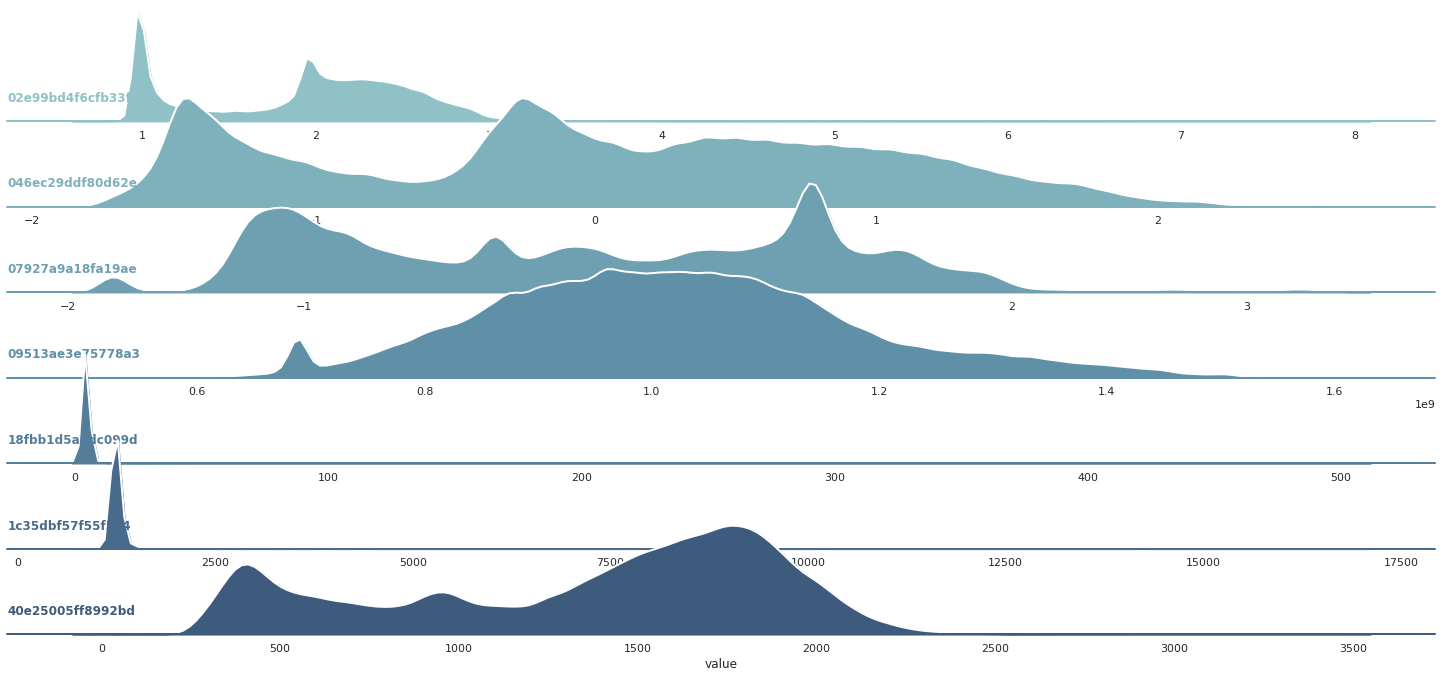

In [49]:
nb_of_kpi = 7
f = train.kpi_id.isin(train.kpi_id.unique()[:nb_of_kpi])

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
grid = sns.FacetGrid(train[f], row="kpi_id", hue="kpi_id", aspect=15, height=1.4, palette=pal, sharex=False, sharey=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

# Draw the densities in a few steps
grid.map(sns.kdeplot, "value", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
grid.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5)
grid.map(label, "value")

grid.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
grid.figure.subplots_adjust(hspace=-.25) # Overlap

# Remove axes details that don't play well with overlap
grid.set_titles("")
grid.set(yticks=[], ylabel="")
grid.despine(bottom=True, left=True)

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler
id = 'kpi_id'
df = train
col = 'value'

scalers = df.groupby(id)[col].apply(lambda x: scaler().fit(x.to_numpy().reshape(-1, 1))).rename('scaler')
display(scalers)

train[f'{col}_scaled'] = train.groupby(id).apply(lambda x: pd.Series(scalers[x[id].iloc[0]].transform(x[col].to_numpy().reshape(-1, 1)).reshape(-1,))).reset_index(drop=True)
val[f'{col}_scaled'] = val.groupby(id).apply(lambda x: pd.Series(scalers[x[id].iloc[0]].transform(x[col].to_numpy().reshape(-1, 1)).reshape(-1,))).reset_index(drop=True)
test[f'{col}_scaled'] = test.groupby(id).apply(lambda x: pd.Series(scalers[x[id].iloc[0]].transform(x[col].to_numpy().reshape(-1, 1)).reshape(-1,))).reset_index(drop=True)

kpi_id
02e99bd4f6cfb33f    StandardScaler()
046ec29ddf80d62e    StandardScaler()
07927a9a18fa19ae    StandardScaler()
09513ae3e75778a3    StandardScaler()
18fbb1d5a5dc099d    StandardScaler()
1c35dbf57f55f5e4    StandardScaler()
40e25005ff8992bd    StandardScaler()
54e8a140f6237526    StandardScaler()
71595dd7171f4540    StandardScaler()
769894baefea4e9e    StandardScaler()
76f4550c43334374    StandardScaler()
7c189dd36f048a6c    StandardScaler()
88cf3a776ba00e7c    StandardScaler()
8a20c229e9860d0c    StandardScaler()
8bef9af9a922e0b3    StandardScaler()
8c892e5525f3e491    StandardScaler()
9bd90500bfd11edb    StandardScaler()
9ee5879409dccef9    StandardScaler()
a40b1df87e3f1c87    StandardScaler()
a5bf5d65261d859a    StandardScaler()
affb01ca2b4f0b45    StandardScaler()
b3b2e6d1a791d63a    StandardScaler()
c58bfcbacb2822d1    StandardScaler()
cff6d3c01e6a6bfa    StandardScaler()
da403e4e3f87c9e0    StandardScaler()
e0770391decc44ce    StandardScaler()
Name: scaler, dtype: object

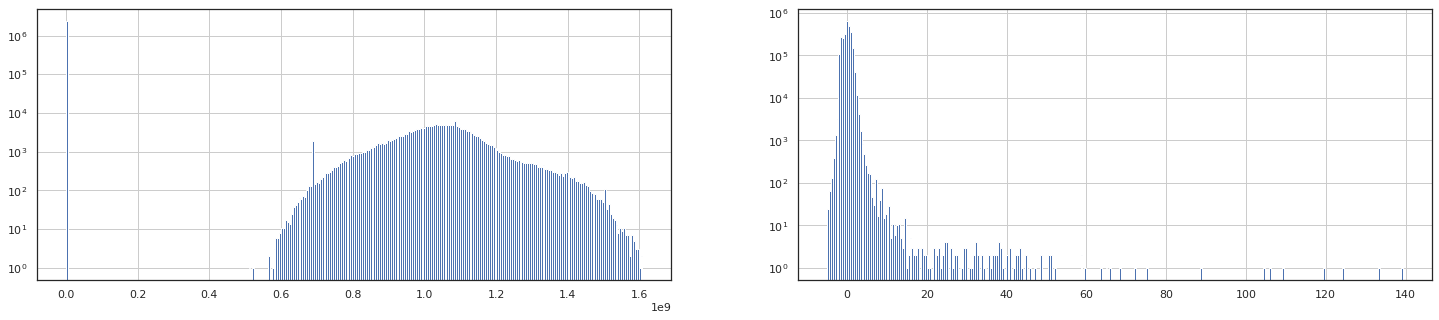

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))

train.value.hist(bins=300, log=True, ax=axs[0])
train.value_scaled.hist(bins=300, log=True, ax=axs[1])
plt.show()

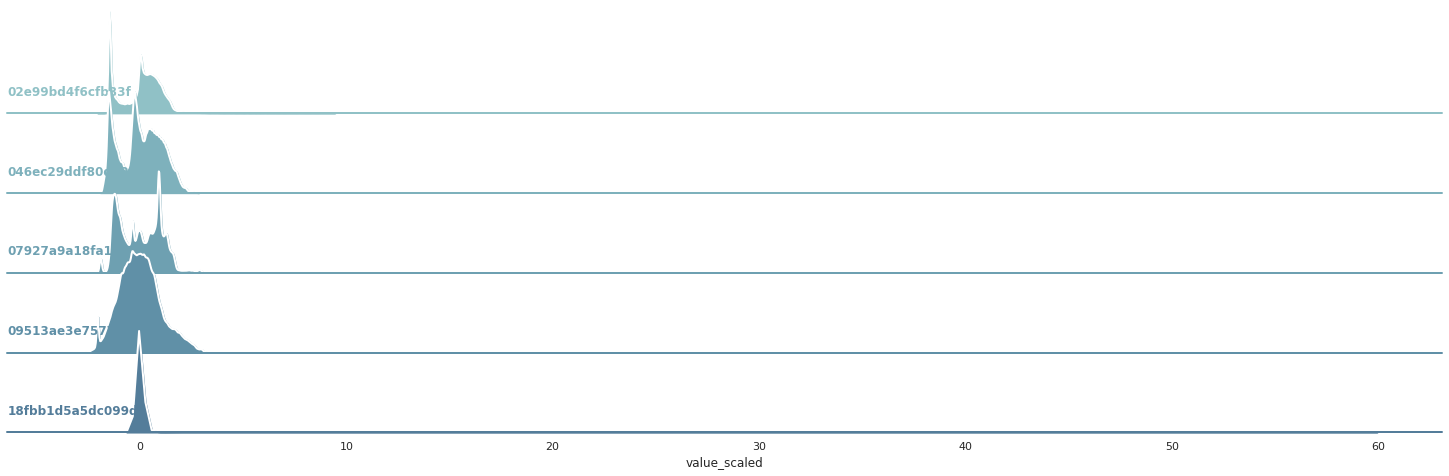

In [18]:
columnsnb_of_kpi = 5
f = train.kpi_id.isin(train.kpi_id.unique()[:nb_of_kpi])

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
grid = sns.FacetGrid(train[f], row="kpi_id", hue="kpi_id", aspect=15, height=1.4, palette=pal, sharex=True, sharey=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

# Draw the densities in a few steps
grid.map(sns.kdeplot, "value_scaled", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
grid.map(sns.kdeplot, "value_scaled", clip_on=False, color="w", lw=2, bw_adjust=.5)
grid.map(label, "value_scaled")

# passing color=None to refline() uses the hue mapping
grid.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Set the subplots to overlap
grid.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
grid.set_titles("")
grid.set(yticks=[], ylabel="")
grid.despine(bottom=True, left=True)